In [1]:
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.integrate import quad
plt.rcParams.update({
    "text.usetex": False,
    "text.latex.preamble": r"\usepackage{amsmath}",  # Optional: Include additional LaTeX packages as needed
    "font.family": "serif",  # You can specify a different font family if desired
})

In [2]:
def plugin_ece_est(confidences, labels, num_bins, p=2, debias=True):
  '''
  Input:
    confidences: (C_1, ... , C_n) \in [0, 1]^n
    labels: (Y_1, ..., Y_n) \in [0, 1]^n
    num_bins: m
    debias: If True, debias the plug-in estimator (only for p = 2)
  Output:
    Plug-in estimator of l_p-ECE(f)^p w.r.t. m equal-width bins
  '''

  indexes = np.floor(num_bins * confidences).astype(int) # reindex to [0, min(num_bins, len(scores))]
  indexes = rankdata(indexes, method='dense') - 1
  counts = np.bincount(indexes)

  if p == 2 and debias:
    counts[counts < 2] = 2
    error = ((np.bincount(indexes, weights=confidences-labels)**2
              - np.bincount(indexes, weights=(confidences-labels)**2)) / (counts-1)).sum()
  else:
    counts[counts == 0] = 1
    error = (np.abs(np.bincount(indexes, weights=confidences-labels))**p / counts**(p - 1)).sum()

  return error / len(confidences)


def adaptive_ece_est(confidences, labels):
  '''
  Input:
    confidences: (C_1, ... , C_n) \in [0, 1]^n
    labels: (Y_1, ..., Y_n) \in [0, 1]^n
  Output:
    Adaptive debiased estimator of l_p-ECE(f)^2 using the dyadic grid of binning numbers
  '''

  num_bins_list = [2**b for b in range(1, np.floor(np.log2(n)-2).astype(int))]
  return np.max([plugin_ece_est(confidences, labels, num_bins, p=2, debias=True) for num_bins in num_bins_list])

def perturb_dist(confidences, smoothness, half_num_waves, scale):
  '''
  This function constructs a un-calibrated model by pertubating the conditional
  expectation E[Y|C] from C. The pertubation is composed of many waves scaled from
  zeta function defined below. The resulted conditional expectation E[Y|C=c] is
  s-Holder smooth with respect to c.

  Input:
    confidences: (C_1, ... , C_n) \in [0, 1]^n
    smoothness: Holder exponent s
    half_num_waves: m
    scale: \rho

  Output:
    The groundtruth condition expectation
    (E[Y|C_1], ... , E[Y|C_n]) where E[Y|C_i] = C_i+sign(C_i-0.5)*rho*m^(-s)*zeta(2*m*C_i)
  '''

  is_inner = (0.25 <= confidences) & (confidences <= 0.75)
  zeta = lambda x: np.exp(-1/x/(1 - x))
  rescale = lambda x: (2*half_num_waves*(x - 0.25)) % 1
  signs = lambda x: (np.floor(2*half_num_waves*(x - 0.25)) % 2)*2-1
  perturbations = is_inner* scale * half_num_waves**(-smoothness) * zeta(rescale(confidences)) * signs(confidences)

  return confidences+perturbations

def real_ece(p, smoothness, half_num_waves, scale):
  '''
  Output:
    The groundtruth l_p-ECE(f)^p under the specific construction
    defined in perturb_dist.
  '''

  zeta = lambda x: np.exp(-p/x/(1 - x))
  res, _ = quad(zeta, 0, 1)
  return scale**p * half_num_waves**(-p*smoothness) * res

In [5]:
def evaluation_calibrated(n, B_list, num_trials, estimate_dict):

  res = {key: np.zeros((num_trials, len(B_list))) for key in estimate_dict.keys()}
  for idx_trial in range(num_trials):
    c = np.random.uniform(0.25, 0.75, size=n)
    y = np.random.binomial(1, c, n) # discrete label

    for key, estimate in estimate_dict.items():
      if key != 'adaptive':
        for idx_B, B in enumerate(B_list):
            res[key][idx_trial][idx_B] = estimate(c, y, B)
      else:
        res[key][idx_trial][idx_B] = estimate(c, y) if idx_B == 0 else res[key][idx_trial][0]
  return res

def evaluation_non_calibrated(n, B_list, s, m, rho, num_trials, estimate_dict):

  res = {key: np.zeros((num_trials, len(B_list))) for key in estimate_dict.keys()}
  for idx_trial in range(num_trials):
    c = np.random.uniform(0.25, 0.75, size=n)
    perturbed_c = perturb_dist(c, s, m, rho)
    y = np.random.binomial(1, perturbed_c, n) # discrete label

    for idx_B, B in enumerate(B_list):
      for key, estimate in estimate_dict.items():
        if key != 'adaptive':
            res[key][idx_trial][idx_B] = estimate(c, y, B)
        else:
          res[key][idx_trial][idx_B] = estimate(c, y) if idx_B == 0 else res[key][idx_trial][0]
  return res

In [3]:
estimate_dict = {'plugin1': lambda c, y, B: plugin_ece_est(c, y, B, 1, False),\
                 'plugin2': lambda c, y, B: plugin_ece_est(c, y, B, 2, False),\
                 'debiased': lambda c, y, B: plugin_ece_est(c, y, B, 2, True),\
                 'adaptive': lambda c, y: adaptive_ece_est(c, y)}

# A synthetic perfectly calibrated toy model with $Y|C\sim {\rm Bernoulli}(C)$.

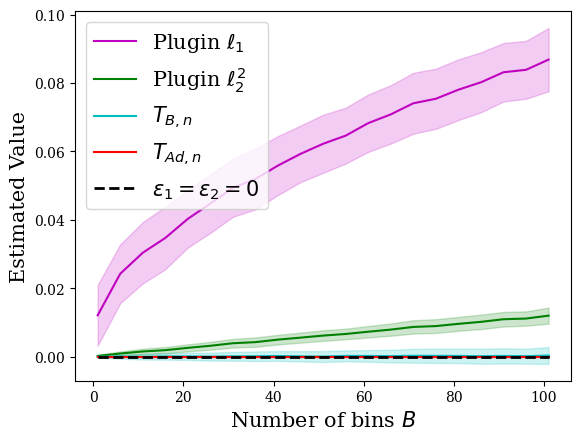

In [6]:
np.random.seed(2024) # reproducibility

n = 1000
num_trials = 300

# perfect calibration, varying number of bins
B_list = range(1, 102, 5)
res = evaluation_calibrated(n, B_list, num_trials, estimate_dict)

plt.plot(B_list, res['plugin1'].mean(axis=0), label='Plugin $\ell_1$', color='m')
plt.fill_between(B_list, res['plugin1'].mean(axis=0)-res['plugin1'].std(axis=0), res['plugin1'].mean(axis=0)+res['plugin1'].std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, res['plugin2'].mean(axis=0), label='Plugin $\ell_2^2$', color='g')
plt.fill_between(B_list, res['plugin2'].mean(axis=0)-res['plugin2'].std(axis=0), res['plugin2'].mean(axis=0)+res['plugin2'].std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, res['debiased'].mean(axis=0), label='$T_{B,n}$', color='c')
plt.fill_between(B_list, res['debiased'].mean(axis=0)-res['debiased'].std(axis=0), res['debiased'].mean(axis=0)+res['debiased'].std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, res['adaptive'].mean(axis=0), label='$T_{Ad,n}$', color='r')
plt.fill_between(B_list, res['adaptive'].mean(axis=0)-res['adaptive'].std(axis=0), res['adaptive'].mean(axis=0)+res['adaptive'].std(axis=0), color='r', alpha=0.2)

plt.plot(B_list, np.zeros_like(B_list), '--', label='$\epsilon_1=\epsilon_2=0$', color='black', linewidth=2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Estimated Value', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

# A synthetic un-calibrated model with $Y|C\sim {\rm Bernoulli}(C+{\rm Perturb}(C))$.

## $n=1000$, $s=1$

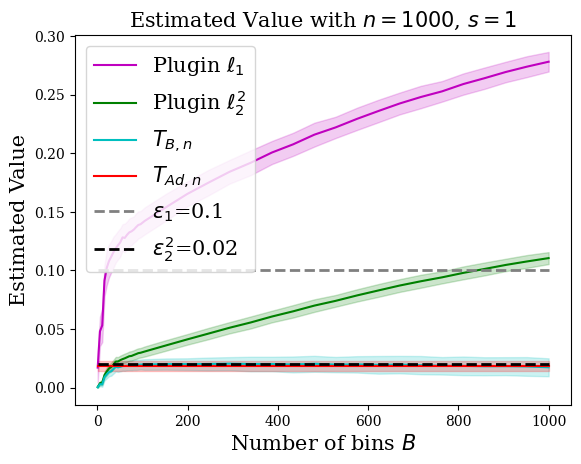

In [16]:
np.random.seed(2024) # reproducibility

n = 1000
s = 1
m = int(n**(2 / (4*s + 1)))//2
rho = 100
num_trials = 300

B_list = list(range(1, 101, 5))+list(np.linspace(105, n, 20).astype(int))
res = evaluation_non_calibrated(n, B_list, s, m, rho, num_trials, estimate_dict)

eps1, eps2_square = real_ece(1, s, m, rho), real_ece(2, s, m, rho)

plt.plot(B_list, res['plugin1'].mean(axis=0), label='Plugin $\ell_1$', color='m')
plt.fill_between(B_list, res['plugin1'].mean(axis=0)-res['plugin1'].std(axis=0), res['plugin1'].mean(axis=0)+res['plugin1'].std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, res['plugin2'].mean(axis=0), label='Plugin $\ell_2^2$', color='g')
plt.fill_between(B_list, res['plugin2'].mean(axis=0)-res['plugin2'].std(axis=0), res['plugin2'].mean(axis=0)+res['plugin2'].std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, res['debiased'].mean(axis=0), label='$T_{B,n}$', color='c')
plt.fill_between(B_list, res['debiased'].mean(axis=0)-res['debiased'].std(axis=0), res['debiased'].mean(axis=0)+res['debiased'].std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, res['adaptive'].mean(axis=0), label='$T_{Ad,n}$', color='r')
plt.fill_between(B_list, res['adaptive'].mean(axis=0)-res['adaptive'].std(axis=0), res['adaptive'].mean(axis=0)+res['adaptive'].std(axis=0), color='r', alpha=0.2)

plt.plot(B_list, np.ones_like(B_list)*eps1,'--', label='$\epsilon_1$='+str(round(eps1, 3)), color='grey', linewidth=2)
plt.plot(B_list, np.ones_like(B_list)*eps2_square,'--', label='$\epsilon_2^2$='+str(round(eps2_square, 3)), color='black', linewidth=2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Estimated Value', fontsize=15)
plt.title(f'Estimated Value with $n={n}$, $s={s}$', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

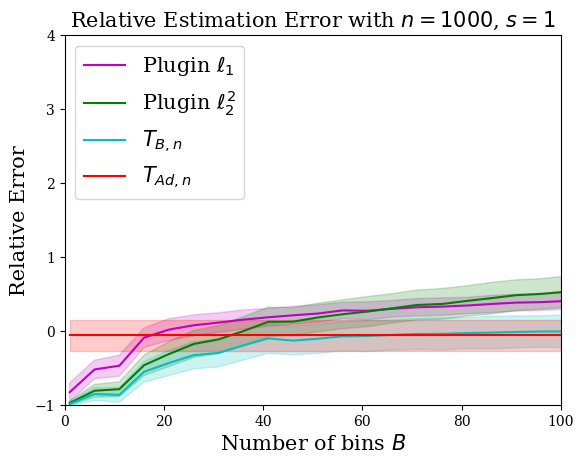

In [17]:
plugin1_rel = (res['plugin1']-eps1)/eps1
plugin2_rel = (res['plugin2']-eps2_square)/eps2_square
debiased_rel = (res['debiased']-eps2_square)/eps2_square
adaptive_rel = (res['adaptive']-eps2_square)/eps2_square

plt.plot(B_list, plugin1_rel.mean(axis=0), label='Plugin $\ell_1$', color='m')
plt.fill_between(B_list, plugin1_rel.mean(axis=0)-plugin1_rel.std(axis=0), plugin1_rel.mean(axis=0)+plugin1_rel.std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, plugin2_rel.mean(axis=0), label='Plugin $\ell_2^2$', color='g')
plt.fill_between(B_list, plugin2_rel.mean(axis=0)-plugin2_rel.std(axis=0), plugin2_rel.mean(axis=0)+plugin2_rel.std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, debiased_rel.mean(axis=0), label='$T_{B,n}$', color='c')
plt.fill_between(B_list, debiased_rel.mean(axis=0)-debiased_rel.std(axis=0), debiased_rel.mean(axis=0)+debiased_rel.std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, np.ones_like(B_list)*adaptive_rel.mean(), label='$T_{Ad,n}$', color='r')
plt.fill_between(B_list, adaptive_rel.mean()-adaptive_rel.std(), adaptive_rel.mean()+adaptive_rel.std(), color='r', alpha=0.2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Relative Error', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.title(f'Relative Estimation Error with $n={n}$, $s={s}$', fontsize=15)
plt.ylim(-1, 4)
plt.xlim(0, 100)
plt.show()

## $n=3000$, $s=0.5$

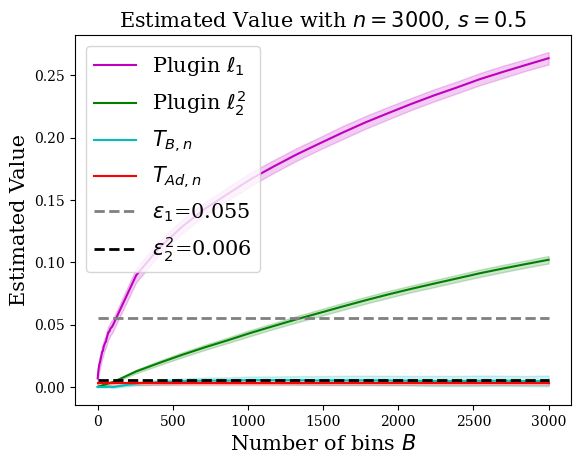

In [18]:
np.random.seed(2024) # reproducibility

n = 3000
s = 0.5
m = int(n**(2 / (4*s + 1)))//2
rho = 80
num_trials = 300


B_list = list(range(1, 101, 5))+list(np.linspace(105, n, 20).astype(int))
res = evaluation_non_calibrated(n, B_list, s, m, rho, num_trials, estimate_dict)

eps1, eps2_square = real_ece(1, s, m, rho), real_ece(2, s, m, rho)

plt.plot(B_list, res['plugin1'].mean(axis=0), label='Plugin $\ell_1$', color='m')
plt.fill_between(B_list, res['plugin1'].mean(axis=0)-res['plugin1'].std(axis=0), res['plugin1'].mean(axis=0)+res['plugin1'].std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, res['plugin2'].mean(axis=0), label='Plugin $\ell_2^2$', color='g')
plt.fill_between(B_list, res['plugin2'].mean(axis=0)-res['plugin2'].std(axis=0), res['plugin2'].mean(axis=0)+res['plugin2'].std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, res['debiased'].mean(axis=0), label='$T_{B,n}$', color='c')
plt.fill_between(B_list, res['debiased'].mean(axis=0)-res['debiased'].std(axis=0), res['debiased'].mean(axis=0)+res['debiased'].std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, res['adaptive'].mean(axis=0), label='$T_{Ad,n}$', color='r')
plt.fill_between(B_list, res['adaptive'].mean(axis=0)-res['adaptive'].std(axis=0), res['adaptive'].mean(axis=0)+res['adaptive'].std(axis=0), color='r', alpha=0.2)

plt.plot(B_list, np.ones_like(B_list)*eps1,'--', label='$\epsilon_1$='+str(round(eps1, 3)), color='grey', linewidth=2)
plt.plot(B_list, np.ones_like(B_list)*eps2_square,'--', label='$\epsilon_2^2$='+str(round(eps2_square, 3)), color='black', linewidth=2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Estimated Value', fontsize=15)
plt.title(f'Estimated Value with $n={n}$, $s={s}$', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

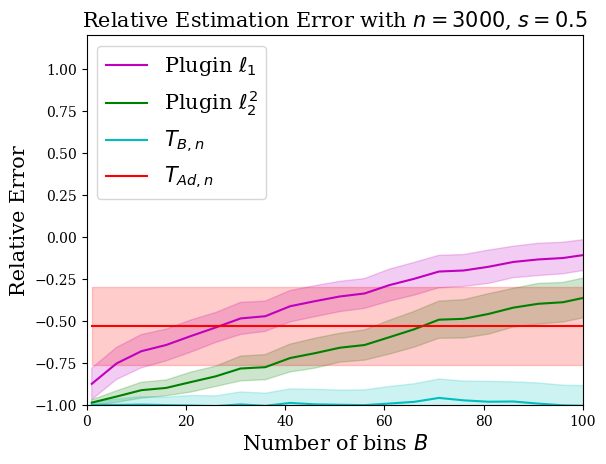

In [20]:
plugin1_rel = (res['plugin1']-eps1)/eps1
plugin2_rel = (res['plugin2']-eps2_square)/eps2_square
debiased_rel = (res['debiased']-eps2_square)/eps2_square
adaptive_rel = (res['adaptive']-eps2_square)/eps2_square

plt.plot(B_list, plugin1_rel.mean(axis=0), label='Plugin $\ell_1$', color='m')
plt.fill_between(B_list, plugin1_rel.mean(axis=0)-plugin1_rel.std(axis=0), plugin1_rel.mean(axis=0)+plugin1_rel.std(axis=0), color='m', alpha=0.2)

plt.plot(B_list, plugin2_rel.mean(axis=0), label='Plugin $\ell_2^2$', color='g')
plt.fill_between(B_list, plugin2_rel.mean(axis=0)-plugin2_rel.std(axis=0), plugin2_rel.mean(axis=0)+plugin2_rel.std(axis=0), color='g', alpha=0.2)

plt.plot(B_list, debiased_rel.mean(axis=0), label='$T_{B,n}$', color='c')
plt.fill_between(B_list, debiased_rel.mean(axis=0)-debiased_rel.std(axis=0), debiased_rel.mean(axis=0)+debiased_rel.std(axis=0), color='c', alpha=0.2)

plt.plot(B_list, np.ones_like(B_list)*adaptive_rel.mean(), label='$T_{Ad,n}$', color='r')
plt.fill_between(B_list, adaptive_rel.mean()-adaptive_rel.std(), adaptive_rel.mean()+adaptive_rel.std(), color='r', alpha=0.2)

plt.xlabel('Number of bins $B$', fontsize=15)
plt.ylabel('Relative Error', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.title(f'Relative Estimation Error with $n={n}$, $s={s}$', fontsize=15)
plt.ylim(-1, 1.2)
plt.xlim(0, 100)
plt.show()